# Batch evaluation of LRP hyperparameters

Goal: Compute 4 different images with a single hyperparameter combination end-to-end and save the results.

Steps:

1. Load 4 different images.
1. Ensure LRP can handle batch processing of multiple images.
1. Run experiment first with a single hyperparameter combination.
1. Define the hyperparameter space.
1. Expand experiment to all 10 different hyperparameter combinations.
   
In a nutshell:

1. ~~Load multiple images.~~
1. ~~Compute LRP for each image.~~
1. ??? Calculate average LRP for all images.
1. Calculate AUC score for Pixel-Flipping curves of all images.

Outlook:

- Run experiments on cluster.
- Expand from 4 to 25-100 images.

## Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from typing import List

import torch

print(f'Batch size = # CPUs available = {multiprocessing.cpu_count()}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED: int = 0
BATCH_SIZE: int = multiprocessing.cpu_count()
NUMBER_OF_BATCHES: int = 1

ROOT: str = '~/Documents/personal/unterlagen/bildung/uni/master/masterarbeit/code/lrp/data'
CLASSES: List[str] = ['axolotl']

Batch size = # CPUs available = 4


## Data Loading

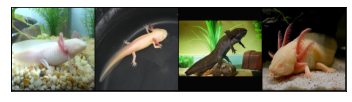

In [3]:
import lrp.plot
from data_loader.core import imagenet_data_loader

dataloader = imagenet_data_loader(root=ROOT, batch_size=BATCH_SIZE, classes=CLASSES, seed=SEED)

# Select first batch from the data loader.
X = next(iter(dataloader))[0].to(device)
lrp.plot.grid_plot_imagenet(X)

## Model

In [4]:
import torchvision

model = torchvision.models.vgg16(pretrained=True)
model.eval()
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## LRP

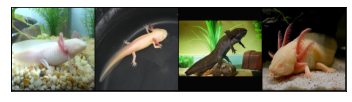

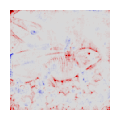

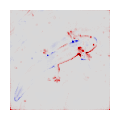

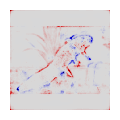

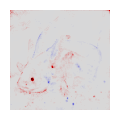

In [5]:
# Params: X
from typing import Dict, List, Tuple, Union

import torch

# import lrp.plot
import lrp.rules as rules
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

lrp.plot.grid_plot_imagenet(X)

# Low and high parameters for zB-rule
CHANNELS: int = 3
HEIGHT: int = 224
WIDTH: int = HEIGHT
shape: Tuple[int] = (BATCH_SIZE, CHANNELS, HEIGHT, WIDTH)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]
lrp_instance: LRP = LRP(model)
lrp_instance.convert_layers(name_map)
R: torch.Tensor = lrp_instance.relevance(X)
lrp_instance.heatmap(R, width=1, height=1)

## Region Perturbation

Also called Pixel-Flipping.

Finished '_flip' in 3.9562 secs
Finished '_flip' in 4.0081 secs
Finished '_flip' in 4.2528 secs
Finished '_flip' in 5.4339 secs
Finished '_flip' in 5.5943 secs
Finished '_flip' in 4.4637 secs
Finished '_flip' in 4.7879 secs
Finished '_flip' in 5.0026 secs
Finished '_flip' in 4.3999 secs
Finished '_flip' in 4.3636 secs
Finished '_flip' in 4.2236 secs
Finished '_flip' in 4.4482 secs
Finished '_flip' in 4.6791 secs
Finished '_flip' in 4.5746 secs
Finished '_flip' in 4.6880 secs
Finished '_flip' in 4.5614 secs
Finished '_flip' in 4.5300 secs
Finished '_flip' in 4.5455 secs
Finished '_flip' in 6.4932 secs
Finished '_flip' in 6.1388 secs
Finished '_flip' in 5.1965 secs
Finished '_flip' in 5.0154 secs
Finished '_flip' in 5.7646 secs
Finished '_flip' in 8.3288 secs
Finished '_flip' in 7.4583 secs
Finished '_flip' in 6.8636 secs
Finished '_flip' in 7.4771 secs
Finished '_flip' in 7.5814 secs
Finished '__call__' in 152.7820 secs


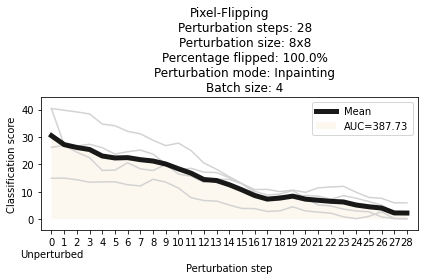

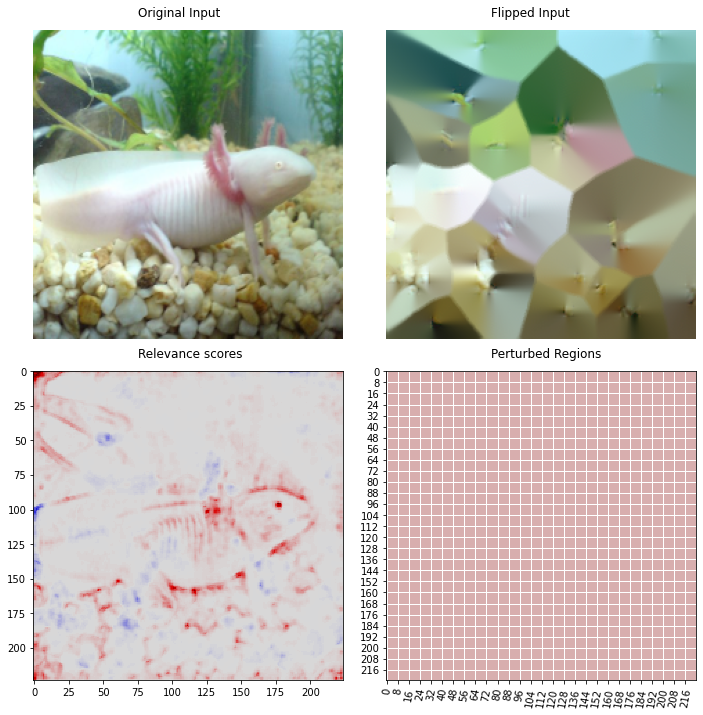

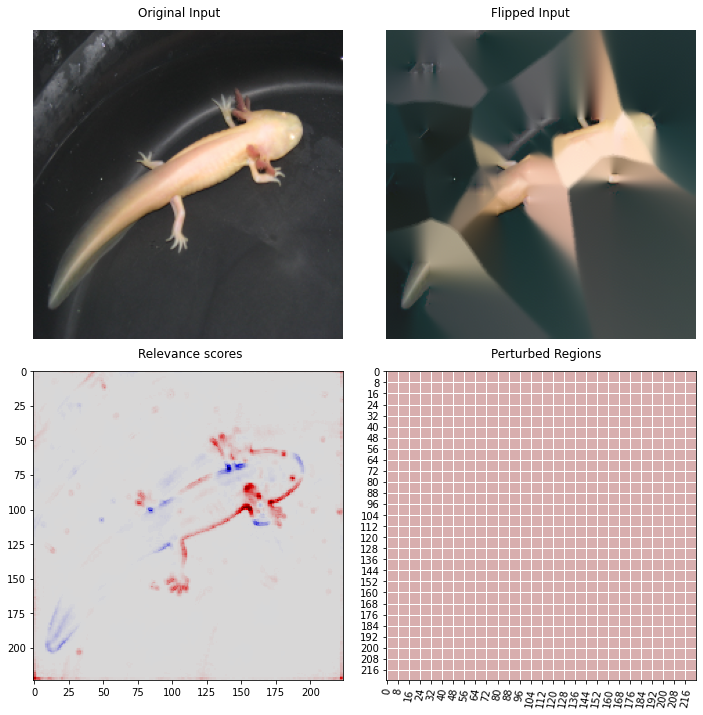

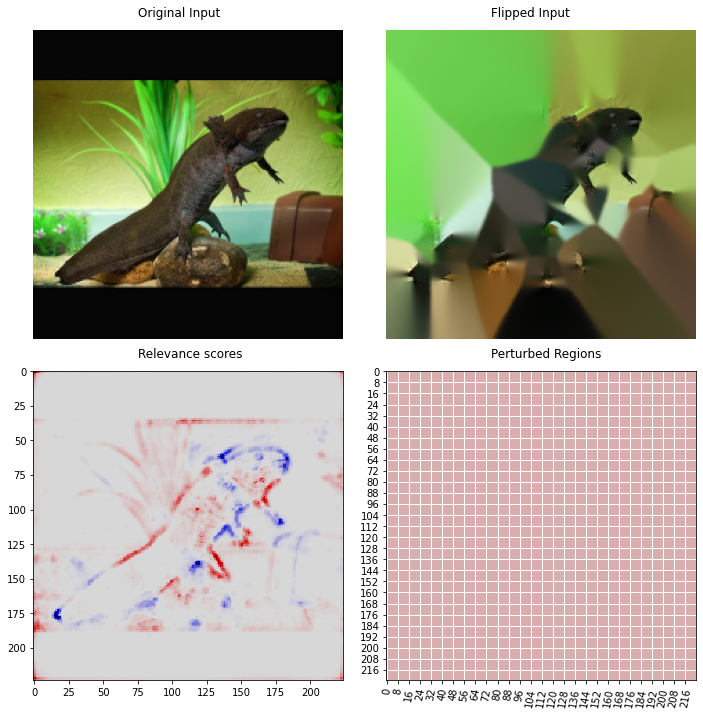

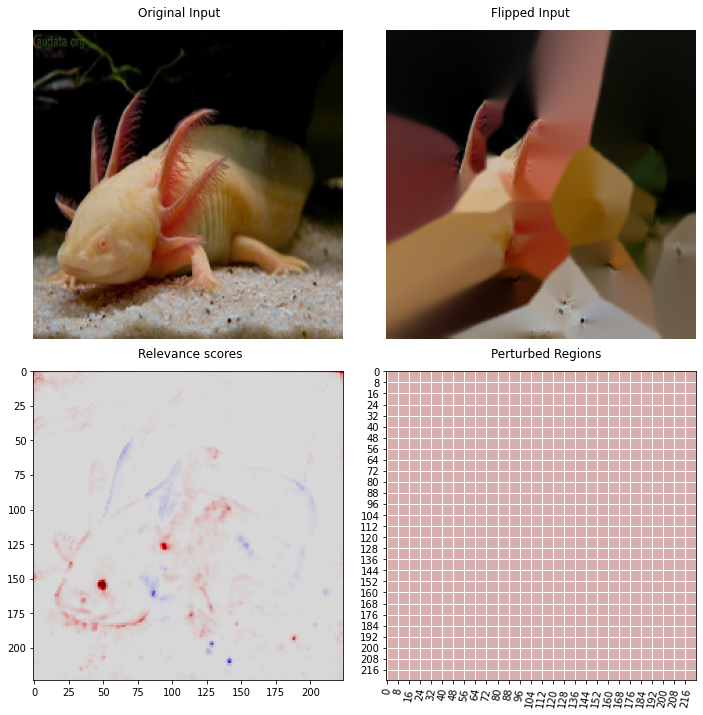

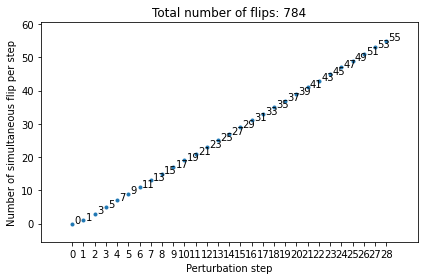

In [6]:
# %%script false --no-raise-error

# Parameters for cell: X, R, lrp_instance
from typing import Callable

from pf.core import PixelFlipping
from pf.perturbation_modes.constants import PerturbModes

perturbation_steps: int = 28
perturbation_size: int = 8

pixel_flipping: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                              perturbation_size=perturbation_size,
                                              perturb_mode=PerturbModes.INPAINTING)
input_nchw: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(SEED)

relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for the given input
# to measure the difference between flips.
# FIXME: Replace 29 by a variable which converts class name to idx
# Access the score of class with index 29 in every image in batch.
forward_pass: Callable[[torch.Tensor],
                       torch.Tensor] = lambda input_nchw: lrp_instance.model(input_nchw)[:, 29]

# Run Pixel-Flipping algorithm
pixel_flipping(input_nchw, relevance_scores_nchw, forward_pass, should_loop=True)

# Plot classification scores throughout perturbation steps
pixel_flipping.plot_class_prediction_scores()
pixel_flipping.plot_image_comparison()
pixel_flipping.plot_number_of_flips_per_step()